In [2]:
#MODULE NAME
import os
import matplotlib as mpl
import matplotlib.colors as colors
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import skimage.exposure as exposure
import pandas as pd
import numpy as np
import subprocess
import snappy
import imageio
import rasterio as rio
import rasterstats as rs
import rasterio.plot 
from glob import iglob
import geopandas as gpd
from pyspatialml import Raster
import seaborn as sns
from rasterio.plot import show
get_ipython().run_line_magic('matplotlib', 'inline')
from osgeo import gdal
import prosail
from prosail import spectral_lib
import numpy as np
import numpy.matlib
import numpy as np
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
#Installing packages

#Needed for step 1 - data generation

#Installing PROSAIL
#!pip install prosail

#latin hypercube stuff
#lets try to do a LHS
#!pip install lhsmdu

#this package as a number of functions to deal with hyperspectral data
#!pip install pysptools

#General purpose: 
import matplotlib.pyplot as plt
import numpy
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd

#PROSPECT+SAIL Radiative transfer mode package
import prosail

#Sampling design package
import lhsmdu

#package to for operations on spectral data
import pysptools as sptool 
from pysptools import distance
#machine learning packages are imported later, nearer to the model
from numpy.random import seed
from numpy.random import rand
import numpy.matlib
import matplotlib.pyplot as plt
import pandas as pd

# Sentinel 2 data

In [4]:
with rasterio.open(r'C:\Users\BSibiya\Desktop\Leaf-Area-Index\sentinel-image\sentinel_LAI.tif') as src:
    blue = src.read(1, masked=True) #B2
    green = src.read(2, masked=True) #B3
    red = src.read(3, masked=True) #B4
    Red_Edge_1 = src.read(4, masked=True) #B5
    Red_Edge_2 = src.read(5, masked=True) #B6
    Red_Edge_3 = src.read(6, masked=True) #B7
    nir = src.read(7, masked=True) #B8
    Red_Edge_4 = src.read(8, masked=True) #B8A
    swir_1 = src.read(9, masked=True) #B11
    swir_2 = src.read(10, masked=True) #B12
    
np.seterr(divide='ignore', invalid='ignore')
VI_output = '/Users/BSibiya/Desktop/Leaf-Area-Index/VI-output/'


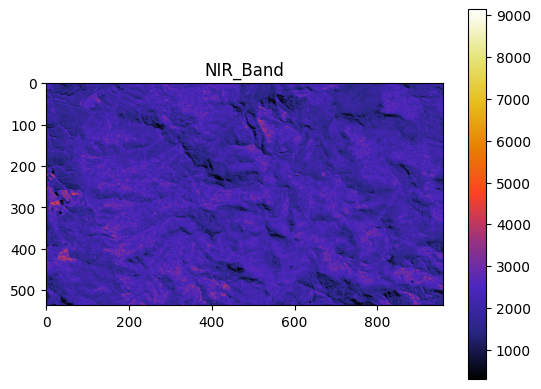

In [5]:
plt.imshow(nir, cmap='CMRmap')
plt.colorbar()
plt.title('NIR_Band')
plt.show()

# Function to calculate vegetation indices

In [8]:
#Function to calculate vegetation indices from band combinations
#Raster_output_name - name of the vegetation index which will be saved 
#VI_name - name of the vegetation index
#cmap_output_name - name of the png file where the file will be stored with colormap applied
#plot_title - title of the image produced 

def create_vegetation_indices(raster_output_name, VI_name, cmap_output_name, plot_title):
    np.seterr(divide='ignore', invalid='ignore')
    kwargs = src.meta
    kwargs.update(
        dtype=rasterio.float32,
        count = 1)
    
    with rasterio.open(VI_output + raster_output_name, 'w', **kwargs) as dst:
        dst.write_band(1, VI_name.astype(rasterio.float32))
    
    plt.imsave(VI_output + cmap_output_name, VI_name, cmap=plt.cm.RdYlGn)
    plt.imshow(VI_name, cmap=cm.RdYlGn)
    plt.colorbar()
    plt.title(plot_title)
    plt.show()
    
#Normalizes numpy arrays into scale -1.0 - 1.0
#array - indicates in this case the array of the image to normalize
def normalize(array):
    array_min, array_max = array.min(-1), array.max(1)
    return ((array - array_min)/(array_max - array_min))

#### Normalized Difference vegetation Index - NDVI

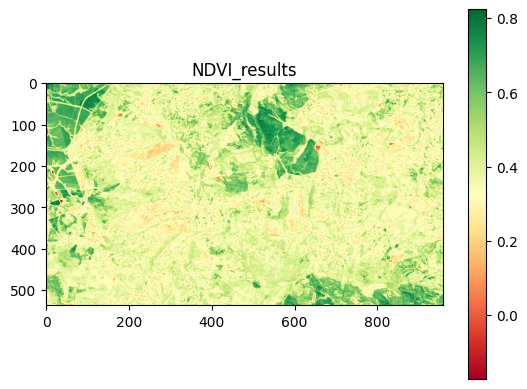

In [9]:
#Equation to calculate NDVI
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)
#create NDVI bands with the use of create_vegetation_indices function from section 3 - user defined functions 
#The result will be written into tiff and png file with the colormap applied
#ndvi_results = create_vegetation_indices('1_NDVI.tif', ndvi, '1_NDVI_cmap.png', 'NDVI_results')

### Soil Adjusted Vegetation Index - SAVI

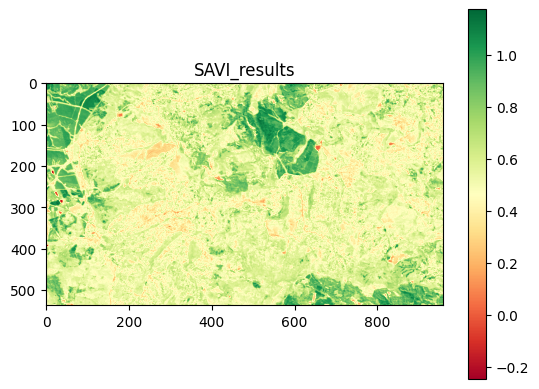

In [10]:
#Calculate SAVI 
l = 0.428 #L parameter assigned
savi = (nir.astype(float) - red.astype(float)) / (nir + red + l) * (1 + l)
#normalize raster results to scale: -1 tp 1:
#savi_n = normalize(savi)
#create SAVI band with the use of create_vegetation_indices function from section 3 - user-defined function
#savi_results = create_vegetation_indices('3_SAVI.tif', savi, '3_SAVI_cmap.png', 'SAVI_results')

### Normalized Difference Moisture Index - NDMI

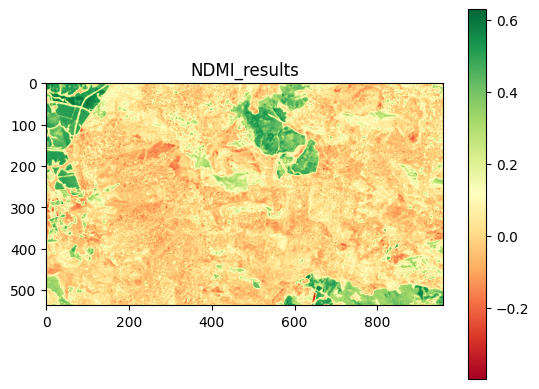

In [15]:
#Equation to calculate NDMIj  
ndmi = (nir.astype(float) - swir_1.astype(float)) / (nir + swir_1)   
#create NDMI bands with the use of create_vegetation_indices function from section 3 - user defined functions    
#The result will be written into tiff and png file with the colormap applied   
#ndmi_results = create_vegetation_indices('1_NDMI.tif', ndmi, '1_NDMI_cmap.png', 'NDMI_results')   

# Measured Spectra

In [6]:
dataframe = r'C:\Users\BSibiya\Desktop\Leaf-Area-Index\LAI-DATASET.xlsx'
df = pd.read_excel(dataframe)

In [7]:
S2_meas = df[['B2', 'B3', 'B4', 'B5','B6', 'B7', 'B8','B8A', 'B11','B12']]

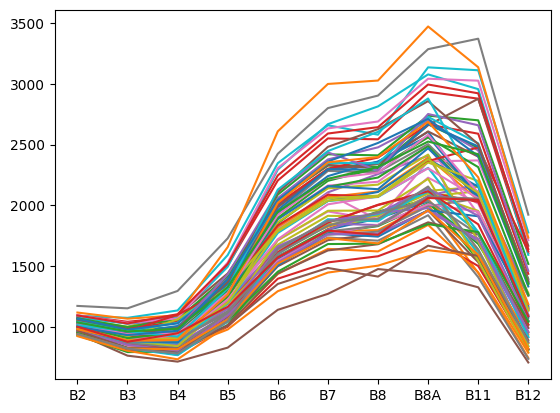

In [8]:
plt.plot(S2_meas.T);

# First a function for better control of the prosail call

In [93]:
np.random.seed(0)
krange=10000
n=1.28
chloro= 15+rand(krange)*30
caroten=rand(krange)*25
brown=rand(krange)*1
EWT=0.01 + rand(krange)*0.02
LMA=0.0025 + rand(krange)*0.005
LAI=1+rand(krange)*5
hot_spot=0.1
tts = 30.4943521645 # solar zenith angle (in degrees)
tto = 0 # sensor/observer zenith angle (in degrees)
psi = 58.1979659437  # Azimuth angle - difference between sun and sensor (in degrees)
typelidf=1 # Leaf angle distribution type
lidfa = -1 # leaf angle distribution parameter a and b (Spherical)
lidfb=0 # Leaf angle distribution
rsoil = 1  # Soil brigthness factor 
psoil = 1 # Dry/Wet soil factor

#soilType=pyPro4SAIL.DEFAULT_SOIL
#sal=len(solar_zenith)
#rho=np.zeros((sal,krange,2101))
rho_out = np.zeros((krange,2101))
for i in range(krange):
    rho_out[i,:] = prosail.run_prosail(n,chloro[i],caroten[i],brown[i], EWT[i], LMA[i], LAI[i], lidfa,hot_spot,tts,tto,psi, typelidf=1, lidfb=0,
                                 factor='DHR', rsoil=0.39, psoil=-0.12)


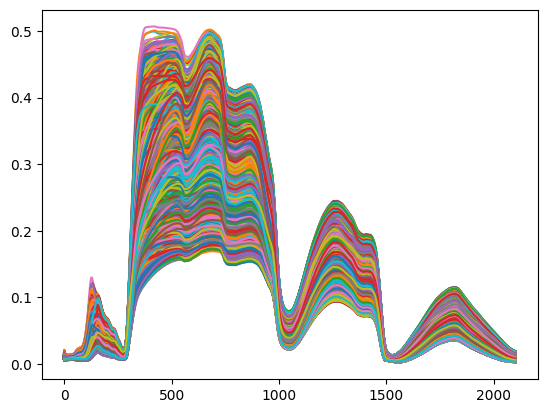

In [94]:
plt.plot(rho_out.T);

### Then a function to convert the input hyperspectral data to Sentinel 2A data using a weighted mean approach

In [73]:
#this function also transforms the hyperspectral data to sentinel data
def Prosail2S2(path2csv, spectra_input):
    #importing pandas
    import pandas as pd
    import numpy
    import numpy as np
    
    s2_table = pd.read_csv(path2csv,sep=";",decimal=",") #check if this is proper, regarding the sep and dec
    s2_table_sel = s2_table[s2_table['SR_WL'].between(400,2500)] #selects all values between 400 and 2500
    spectra_input_df = pd.DataFrame(data=spectra_input,columns=["rho"],index=s2_table_sel.index) #transforms the input array into a pandas df with the column name rho and row.index = to the original input table

  
    rho_s2 = s2_table_sel.multiply(spectra_input_df['rho'],axis="index") #calculates the numerator
    w_band_sum = s2_table_sel.sum(axis=0,skipna = True) #calculates the denominator

    output = (rho_s2.sum(axis=0)/w_band_sum).rename_axis("ID").values #runs the weighted mean and converts the output to a numpy array

    return output[1:] #removes the first value because it represents the wavelength column

#please LOAD THTE FILE NOW
filepath="/Users/BSibiya/Desktop/Sandberg Fynbos Reserve/S2_response.csv"

In [74]:
tr_rho_s = np.zeros((10000, 10))
for i in range(10000):
    tr_rho_s[i, :] = Prosail2S2(filepath,  rho_out[i,0:2101].T)[np.array((1,2,3,4,5,6,7,8,11,12))]
print(tr_rho_s.shape)

S2_sim = pd.DataFrame(tr_rho_s, columns = ('B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12'))


(10000, 10)


In [75]:
S2_sim

,B2,B3,B4,B5,B6,B7,B8,B8A,B11,B12
0,0.008623,0.035223,0.011258,0.070890,0.215121,0.265298,0.286887,0.298554,0.119418,0.043666
1,0.014147,0.034267,0.008951,0.058134,0.180947,0.205865,0.208418,0.209646,0.115511,0.050672
2,0.010186,0.026622,0.010342,0.060403,0.183630,0.254811,0.314553,0.351102,0.182472,0.075387
3,0.021615,0.039322,0.011589,0.075578,0.256973,0.338093,0.378233,0.400521,0.125205,0.044475
4,0.018677,0.030950,0.012262,0.068001,0.185445,0.253010,0.311127,0.346363,0.148116,0.056749
...,...,...,...,...,...,...,...,...,...,...
9995,0.008613,0.031698,0.011196,0.068843,0.216444,0.290162,0.338721,0.367002,0.130785,0.046214
9996,0.013072,0.038388,0.013149,0.076170,0.205467,0.255731,0.283652,0.299082,0.104889,0.034380
9997,0.008845,0.022697,0.008710,0.050070,0.148614,0.191668,0.218678,0.234093,0.123171,0.050032
9998,0.012729,0.044675,0.022148,0.090906,0.175436,0.213159,0.240972,0.256783,0.133285,0.051871


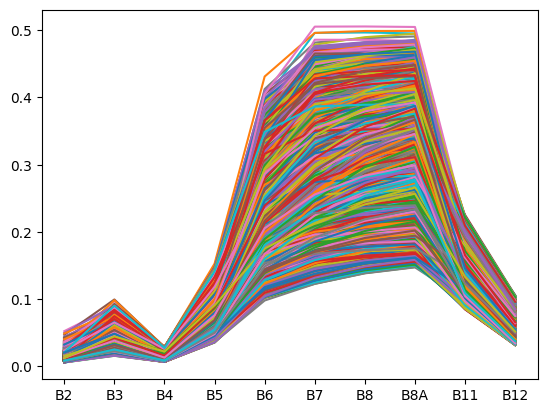

In [76]:
plt.plot(S2_sim.T);

In [77]:
meas=np.array(S2_meas)/np.mean(np.array(S2_meas))*np.mean(np.array(S2_sim))
for i in np.arange(40):
#     print(np.sum((np.array(simulated)-np.array(measured)[i,:])**2,axis=1))
    mses=np.sum((np.array(S2_sim)-meas[i,:])**2,axis=1)
    ind=np.argmin(mses)
    print(ind, mses[ind])

9856 0.008132039248082486
9856 0.007533055514940519
9856 0.00841155856615854
9106 0.009355051742901221
7519 0.009434312256560844
6019 0.009842885678125439
7519 0.014907364106610092
4612 0.013174339818354835
7519 0.02190111604782828
2032 0.03189961583358404
4612 0.013518380002872912
9856 0.009364485349986415
4612 0.018667229044461508
8040 0.026038820445688154
4612 0.01921391629156255
4612 0.01659525100065218
8978 0.020793098946359095
9106 0.00761276259466
4684 0.017676464599414316
2032 0.024139619349201447
4612 0.0131354135176519
8978 0.013596427567313898
9856 0.009495318123703958
4684 0.016110008858305887
4684 0.017837303588638734
4612 0.02849554136157125
8978 0.012003604707950614
4684 0.017341870908258752
4684 0.014088556319223969
9856 0.007576459070938462
8978 0.016630876202766758
8196 0.012438727132827645
8978 0.011714333284276585
4612 0.020661336465016163
9856 0.010531067478836255
9106 0.008139381809475002
4684 0.013441387103458833
2032 0.04050915034386697
9856 0.007783482282733107

In [83]:
new_data_simulated = S2_sim.T
new_data_measured = S2_meas.T
new_data_simulated

,0,1,2,3,4,5,6,7,8,9,...,9990,9991,9992,9993,9994,9995,9996,9997,9998,9999
B2,0.008623,0.014147,0.010186,0.021615,0.018677,0.007511,0.009773,0.009856,0.011799,0.008320,...,0.009868,0.010270,0.009603,0.009299,0.007694,0.008613,0.013072,0.008845,0.012729,0.008549
B3,0.035223,0.034267,0.026622,0.039322,0.030950,0.026360,0.029764,0.023224,0.024132,0.046306,...,0.033087,0.039072,0.038520,0.042806,0.024227,0.031698,0.038388,0.022697,0.044675,0.025318
B4,0.011258,0.008951,0.010342,0.011589,0.012262,0.009878,0.012109,0.008561,0.008289,0.013353,...,0.010113,0.016957,0.018929,0.016059,0.009336,0.011196,0.013149,0.008710,0.022148,0.008878
B5,0.070890,0.058134,0.060403,0.075578,0.068001,0.059080,0.067685,0.052006,0.051025,0.080792,...,0.067177,0.084515,0.086656,0.089184,0.055677,0.068843,0.076170,0.050070,0.090906,0.054623
B6,0.215121,0.180947,0.183630,0.256973,0.185445,0.176307,0.186300,0.185287,0.187182,0.215639,...,0.246702,0.199519,0.189575,0.238880,0.175778,0.216444,0.205467,0.148614,0.175436,0.180455
B7,0.265298,0.205865,0.254811,0.338093,0.253010,0.227420,0.253588,0.256865,0.249883,0.241637,...,0.328283,0.258751,0.247050,0.308939,0.234156,0.290162,0.255731,0.191668,0.213159,0.233549
B8,0.286887,0.208418,0.314553,0.378233,0.311127,0.258346,0.310122,0.305605,0.283936,0.245447,...,0.366189,0.305866,0.296814,0.356046,0.272894,0.338721,0.283652,0.218678,0.240972,0.261985
B8A,0.298554,0.209646,0.351102,0.400521,0.346363,0.275844,0.344135,0.334320,0.303379,0.247258,...,0.387418,0.333557,0.326342,0.383349,0.295382,0.367002,0.299082,0.234093,0.256783,0.277903
B11,0.119418,0.115511,0.182472,0.125205,0.148116,0.111321,0.113030,0.133152,0.150160,0.120866,...,0.145757,0.119030,0.113852,0.165404,0.134138,0.130785,0.104889,0.123171,0.133285,0.109052
B12,0.043666,0.050672,0.075387,0.044475,0.056749,0.040284,0.037454,0.049081,0.058032,0.050366,...,0.053936,0.039636,0.037699,0.065807,0.049813,0.046214,0.034380,0.050032,0.051871,0.037638


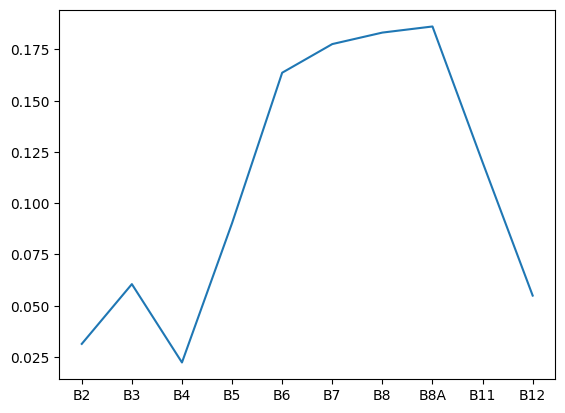

In [88]:
best_simulated = new_data_simulated[[9856]]
plt.plot(best_simulated);

In [89]:
inner = pd.concat([new_data_measured, best_simulated], axis = 1)
inner

,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,9856
B2,961.0,956.0,973.0,957.5,981.0,946.0,1016.0,1008.0,1064.5,1093.0,...,990.5,1018.0,943.5,990.0,1016.0,1002.5,982.5,1038.5,1003.0,0.031382
B3,845.5,854.0,858.0,811.5,886.0,765.0,898.5,910.0,1003.5,1076.0,...,942.0,941.5,823.5,892.0,965.0,934.0,889.5,964.0,879.0,0.060532
B4,819.0,803.0,852.0,787.0,858.0,716.0,921.5,893.0,1100.5,1136.5,...,990.5,948.0,783.0,904.5,921.0,970.0,894.0,986.0,949.5,0.022310
B5,1071.5,1093.5,1084.5,1003.0,1199.5,831.0,1209.5,1263.0,1297.0,1592.0,...,1372.5,1281.0,1049.0,1200.5,1317.0,1393.5,1267.5,1328.5,1167.0,0.090297
B6,1560.0,1574.0,1581.0,1397.5,1813.0,1142.0,1713.5,1942.0,1677.5,2347.5,...,2107.0,1921.5,1645.5,1797.5,2130.0,2043.0,2021.0,1948.0,1573.0,0.163657
B7,1801.0,1787.0,1804.5,1531.5,2107.5,1273.0,1950.5,2283.5,1914.5,2659.0,...,2481.5,2219.0,1871.5,2059.5,2447.0,2361.0,2354.5,2218.5,1793.5,0.177632
B8,1892.5,1797.0,1950.0,1582.0,2258.0,1477.0,1880.5,2273.5,1909.5,2581.5,...,2627.0,2268.5,1888.0,2080.5,2605.0,2513.5,2398.0,2316.5,1758.0,0.183235
B8A,2033.0,2004.5,2048.5,1737.5,2408.5,1436.0,2228.0,2504.0,2119.5,3135.0,...,2857.5,2580.5,2155.5,2380.0,2879.0,2711.0,2687.5,2525.0,2061.0,0.186215
B11,1569.5,1445.0,1552.0,1502.0,1714.5,1327.0,2016.0,2101.5,2153.0,3111.0,...,2504.0,2104.5,1639.0,2101.5,2164.0,2406.0,2231.5,2421.0,2045.0,0.119988
B12,819.5,746.5,811.5,816.0,872.0,709.0,1102.0,1140.0,1269.5,1777.5,...,1374.0,1101.0,878.0,1141.5,1091.0,1334.0,1188.0,1351.5,1088.5,0.054938


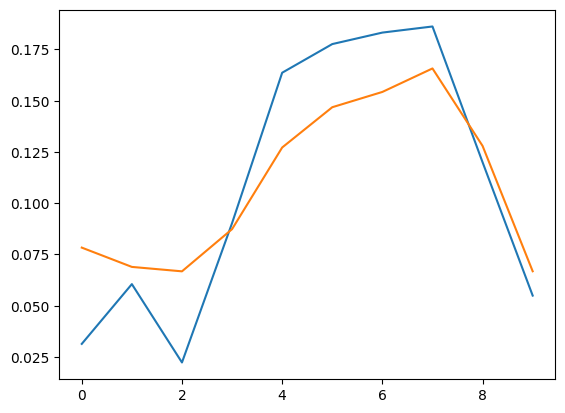

In [90]:
plt.plot(np.array(inner)[:,-1]);
plt.plot(np.array(inner)[:,0]/np.mean(np.array(inner)[:,0])*np.mean(np.array(inner)[:,-1]));    